In [1]:
%load_ext autoreload
%autoreload 2

Si uso un input size de 512x512, la última feature de una resnet me da 16x16(=256, que es lo mínimo que necesito para detectar todas las geoms).

In [2]:
import timm
import torch 

r18 = timm.create_model('resnet18', features_only=True)
fs = r18(torch.randn(5, 3, 512, 512))
for f in fs:
	print(f.shape)

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 16, 16])


Esto se lo paso a dos conv layers para sacar polys y lines.

In [3]:
polys = torch.nn.Conv2d(512, 148+1, 3, padding=1)(fs[-1])
lines = torch.nn.Conv2d(512, 4+1, 3, padding=1)(fs[-1])

polys.shape, lines.shape

(torch.Size([5, 149, 16, 16]), torch.Size([5, 5, 16, 16]))

Si hago un rearrange de las últimas dos dims, obtengo el número de geoms.

In [4]:
from einops import rearrange

polys = rearrange(polys, 'b c h w -> b c (h w)')
lines = rearrange(lines, 'b c h w -> b c (h w)')

polys.shape, lines.shape

(torch.Size([5, 149, 256]), torch.Size([5, 5, 256]))

In [163]:
from src.dm import BaselineDM

dm = BaselineDM()
dm.setup()

In [164]:
dm.df

,image,location,label,date
0,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
1,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
2,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
3,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
4,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
...,...,...,...,...
1597,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1598,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1599,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1600,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post


In [296]:
dm = BaselineDM(trans={
	# 'center_crop': {'size': (512, 512), 'p': 1},
	'random_crop': {'size': (512, 512), 'p': 1.},
})

dm.setup()

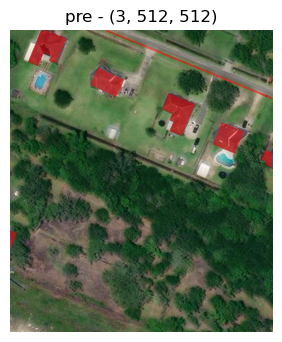

In [486]:
from rasterio.plot import show 
import matplotlib.pyplot as plt
import random 

fig = plt.figure(dpi=100)
ax = plt.subplot(111)
img, geom, transform, date = dm.ds_train[random.randint(0, len(dm.ds_train))]
# img, geom, transform, date = dm.ds_train[0]
show(img, ax=ax, transform=transform)
flooded = geom[geom.flooded == 'yes']
if len(flooded) > 0:
	flooded.plot(ax=ax, color='blue', alpha=0.5)
no_flooded = geom[geom.flooded != 'yes']
if len(no_flooded) > 0:
	no_flooded.plot(ax=ax, color='red', alpha=0.5)
ax.set_title(f'{date} - {img.shape}')
ax.axis('off')
plt.show()

Pasar a WKT en pixel coords

In [488]:
geom.geometry

1     POLYGON ((-90.02851 29.79030, -90.02856 29.790...
5     POLYGON ((-90.02833 29.79135, -90.02837 29.791...
6     POLYGON ((-90.02779 29.79120, -90.02785 29.791...
7     POLYGON ((-90.02740 29.79087, -90.02749 29.790...
8     POLYGON ((-90.02713 29.79095, -90.02698 29.790...
9     POLYGON ((-90.02684 29.79070, -90.02683 29.790...
29    LINESTRING (-90.02791 29.79148, -90.02679 29.7...
Name: geometry, dtype: geometry